训练集样本: (1151, 686), 测试集样本: (288, 686)
各类别样本数：
printability_label
1    877
0    274
Name: count, dtype: int64

各类别占比（%）：
printability_label
1    76.19
0    23.81
Name: proportion, dtype: float64


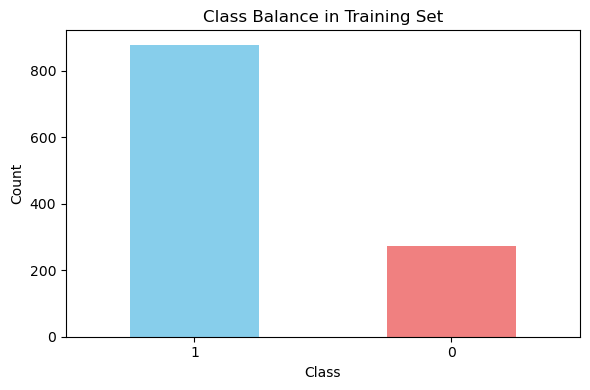

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[0]	train-logloss:0.84392	test-logloss:0.54362
[100]	train-logloss:0.46517	test-logloss:0.45771
[200]	train-logloss:0.37121	test-logloss:0.45100
[300]	train-logloss:0.32594	test-logloss:0.43815
[400]	train-logloss:0.29790	test-logloss:0.42663
[500]	train-logloss:0.27695	test-logloss:0.41770
[600]	train-logloss:0.25902	test-logloss:0.40945
[700]	train-logloss:0.24418	test-logloss:0.40317
[800]	train-logloss:0.23211	test-logloss:0.39615
[900]	train-logloss:0.22080	test-logloss:0.39003
[1000]	train-logloss:0.21133	test-logloss:0.38433
[1041]	train-logloss:0.20776	test-logloss:0.38326
自动找到最佳 F1 阈值为: 0.3913, 对应 F1: 0.6842
Accuracy: 0.8299
ROC-AUC: 0.8581
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.75      0.68        68
           1       0.92      0.85      0.88       220

    accuracy                           0.83       288
   macro avg       0.77      0.80      0.78       288
weighted avg       0.85      0.83      0.84    

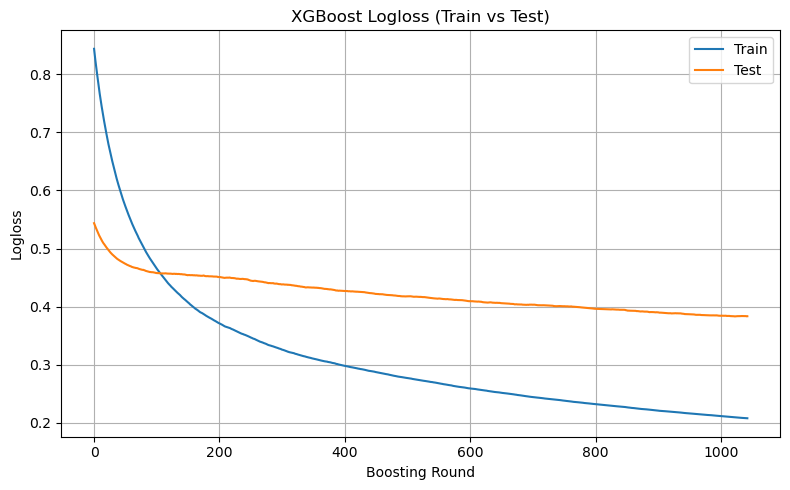

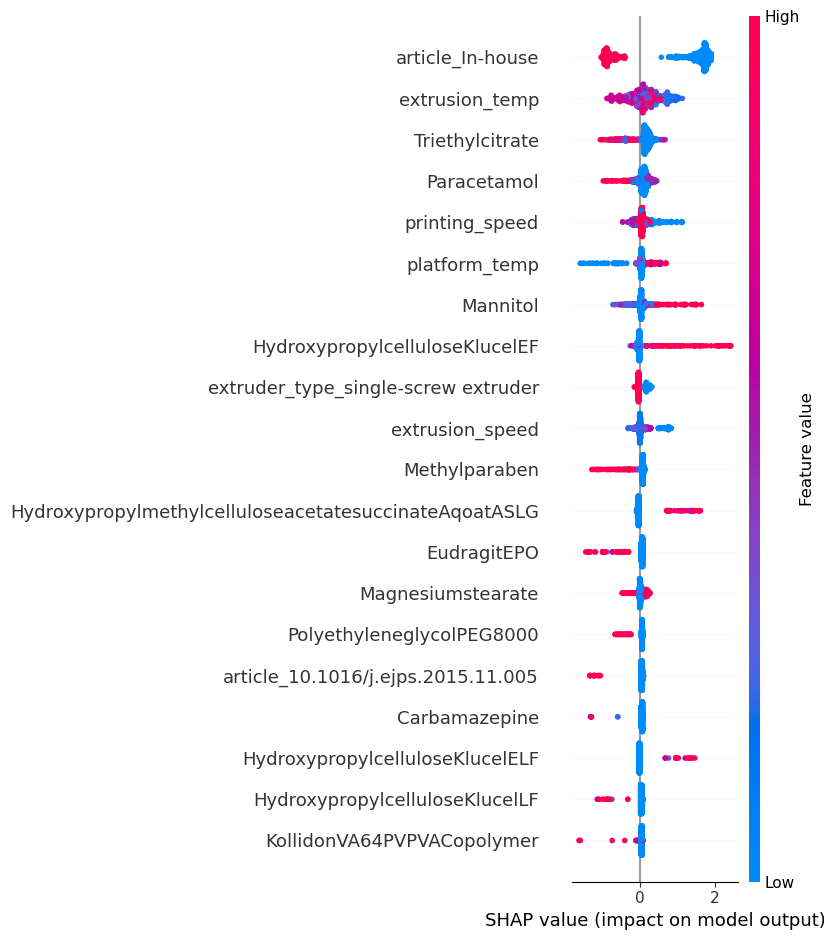

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import shap
from imblearn.over_sampling import SMOTE

# 1. 读入数据
df = pd.read_excel(r"D:\ML-3DPrinting-Project\data\7.7\original_dataset.xlsx")

# 2. 丢弃缺失超过 50% 的列
df = df.dropna(axis=1, thresh=int(len(df)*0.5)).copy()

# 3. 处理目标变量，并筛除填充后仍为 'unknown' 的行
df['printability'] = df['printability'].fillna('unknown')
df = df[df['printability'] != 'unknown'].reset_index(drop=True)
df['printability_label'] = df['printability'].map({'yes': 1, 'no': 0})

# 4. 分离特征和标签
y = df['printability_label']
X = df.drop(columns=['printability', 'printability_label'])

# 5. 生成 missing indicators
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
missing_flags = pd.DataFrame({f"{c}_was_missing": X[c].isna().astype(int) for c in num_cols})
X = pd.concat([X, missing_flags], axis=1)

# 6. 填补缺失：数值填 0，类别填 'missing'
X[num_cols] = X[num_cols].fillna(0)
cat_cols = X.select_dtypes(include=['object', 'category']).columns
X[cat_cols] = X[cat_cols].fillna('missing')

# 7. 先划分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"训练集样本: {X_train.shape}, 测试集样本: {X_test.shape}")


#--------------------------------------------------------------------------

# 1. 样本数统计
counts = y_train.value_counts()
print("各类别样本数：")
print(counts)

# 2. 样本占比
pct = y_train.value_counts(normalize=True) * 100
print("\n各类别占比（%）：")
print(pct.round(2))

# 3. 柱状图可视化
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title("Class Balance in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 8. 类别变量 One-Hot 编码
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc  = pd.get_dummies(X_test, drop_first=True)
# 对齐列（训练集中没有的补 0）
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
cols = X_train_enc.columns.tolist()

# 9. 数值标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled  = scaler.transform(X_test_enc)

# 10. 处理类别不平衡（可选 SMOTE，也可以只用 scale_pos_weight）
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

# 11. 构造 DMatrix
dtrain = xgb.DMatrix(X_res, label=y_res)
dtest  = xgb.DMatrix(X_test_scaled, label=y_test)

# 12. 计算 scale_pos_weight（若只用 weight 不用 SMOTE）
#neg, pos = np.bincount(y_train)
#if pos == 0:
   # raise ValueError("训练集中没有正例！")
#scale_pos_weight = neg / pos

# 13. XGBoost 参数 & 训练
params = {
    'eta': 0.01,
    'objective': 'binary:logistic',
    'subsample': 0.5,
    'base_score': y_train.mean(),
    #'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss'
}
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=100
)

# 14. 评估
from sklearn.metrics import precision_recall_curve
y_pred_proba = model.predict(dtest)
# 概率转成 class=0 的置信度（因为 F1 是以 class=0 为主评估对象）
probs_0 = 1 - y_pred_proba

# 计算 PR 曲线
prec, rec, thr = precision_recall_curve((y_test == 0).astype(int), probs_0)

# 计算每个阈值下的 F1
f1 = 2 * prec * rec / (prec + rec + 1e-20)
best_idx = f1.argmax()
best_thr = thr[best_idx]

print(f"自动找到最佳 F1 阈值为: {best_thr:.4f}, 对应 F1: {f1[best_idx]:.4f}")

# 用这个最佳阈值分类
y_pred_label = np.where(probs_0 > best_thr, 0, 1)

print(f"Accuracy: {accuracy_score(y_test, y_pred_label):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_label))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_label))

# 15. 绘制 Logloss 曲线
epochs = len(evals_result['train']['logloss'])
x_axis = range(epochs)
plt.figure(figsize=(8,5))
plt.plot(x_axis, evals_result['train']['logloss'], label='Train')
plt.plot(x_axis, evals_result['test']['logloss'],  label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss (Train vs Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)

shap.summary_plot(shap_values, X_train_scaled, feature_names=X_train_enc.columns)


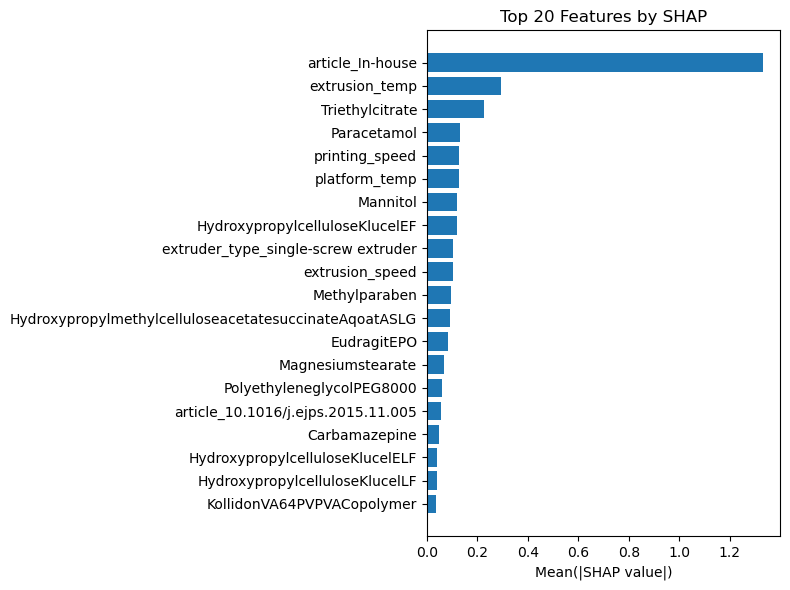

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 平均每个特征的SHAP绝对值（越大越重要）
mean_shap = np.abs(shap_values).mean(axis=0)

# 构造DataFrame，便于排序和展示
shap_df = pd.DataFrame({
    'feature': cols,  
    'mean_abs_shap': mean_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# 取 Top 70 特征
shap_top_70 = shap_df.head(70)
shap_top_features = shap_top_70['feature'].tolist()

# 可视化 Top 20
plt.figure(figsize=(8, 6))
plt.barh(shap_top_70['feature'][:20][::-1], shap_top_70['mean_abs_shap'][:20][::-1])
plt.title("Top 20 Features by SHAP")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()

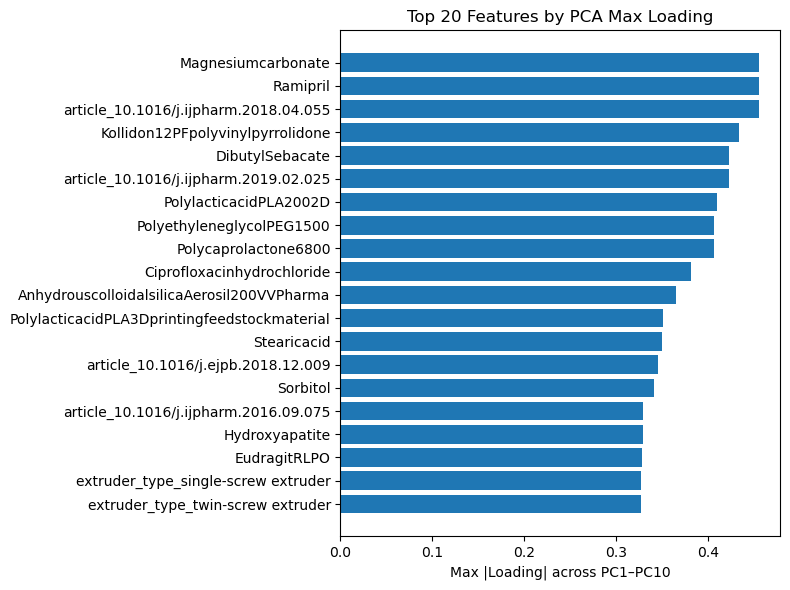

In [3]:
from sklearn.decomposition import PCA

# 设置保留主成分个数
pca = PCA(n_components=10, random_state=42)
pca.fit(X_train_scaled)

# 获取每个主成分对应的所有特征 loading
loadings = np.abs(pca.components_)  

# 计算每个特征在所有主成分中的“最大 loading”
max_loading_per_feature = loadings.max(axis=0)

# 映射回特征名
pca_df = pd.DataFrame({
    'feature': cols,
    'max_loading': max_loading_per_feature
}).sort_values(by='max_loading', ascending=False)

# 取 Top 70 特征
pca_top_70 = pca_df.head(70)
pca_top_features = pca_top_70['feature'].tolist()

# 可视化 Top 20 特征的 loading 值
plt.figure(figsize=(8, 6))
plt.barh(pca_top_70['feature'][:20][::-1], pca_top_70['max_loading'][:20][::-1])
plt.title("Top 20 Features by PCA Max Loading")
plt.xlabel("Max |Loading| across PC1–PC10")
plt.tight_layout()
plt.show()


Epoch 0 - Loss: 0.6827, Attention: μ=0.0013, σ=0.0020
Epoch 10 - Loss: 0.1504, Attention: μ=0.0013, σ=0.0320
Epoch 20 - Loss: 0.0670, Attention: μ=0.0013, σ=0.0323
Epoch 30 - Loss: 0.0737, Attention: μ=0.0013, σ=0.0324
Epoch 40 - Loss: 0.0493, Attention: μ=0.0013, σ=0.0322


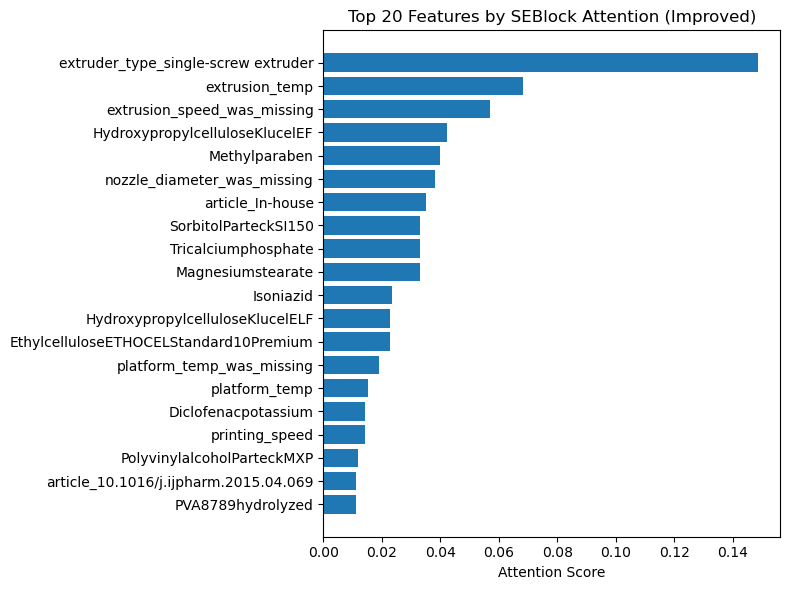

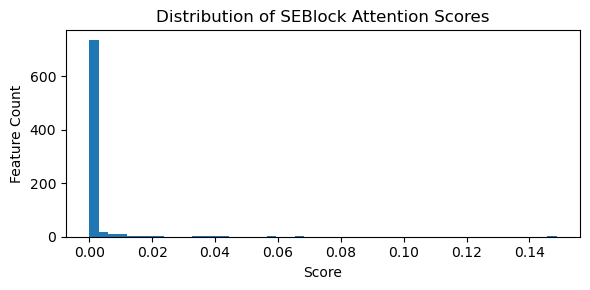

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 转换为 PyTorch 格式
X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. 改进版 SEBlock 模型：用 Softmax 做特征级注意力归一化
class SEBlockMLP(nn.Module):
    def __init__(self, input_dim):
        super(SEBlockMLP, self).__init__()
        self.se = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Softmax(dim=1)  # 改成 Softmax，特征间相对权重
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
#self.classifier 是一个简单的 2 层 MLP，用于分类
    
    def forward(self, x):
        weights = self.se(x)           # 输出每个特征的注意力分数
        x_weighted = x * weights       # 加权后的特征输入分类器
        out = self.classifier(x_weighted)
        return out, weights

# 3. 初始化模型
model = SEBlockMLP(X_train_scaled.shape[1])
neg, pos = np.bincount(y.values)
pos_weight = torch.tensor([neg / pos], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练模型
for epoch in range(50):
    for xb, yb in loader:
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            _, weights = model(X_tensor)
            mean_score = weights.mean().item()
            std_score = weights.std().item()
            print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Attention: μ={mean_score:.4f}, σ={std_score:.4f}")

# 5. 提取注意力特征得分（取均值）
with torch.no_grad():
    _, final_weights = model(X_tensor)
    feature_scores = final_weights.mean(dim=0).numpy()

#这一步提取的是所有样本中每个特征的平均注意力分数（作为特征重要性）；
#转换为 NumPy 后用于可视化/排序。

# 6. 构造 DataFrame
se_df = pd.DataFrame({
    'feature': cols,
    'attention_score': feature_scores
}).sort_values(by='attention_score', ascending=False)

# 7. 取 Top 70 特征
se_top_70 = se_df.head(70)
se_top_features = se_top_70['feature'].tolist()

# 8. 可视化 Top 20
plt.figure(figsize=(8, 6))
plt.barh(se_top_70['feature'][:20][::-1], se_top_70['attention_score'][:20][::-1])
plt.title("Top 20 Features by SEBlock Attention (Improved)")
plt.xlabel("Attention Score")
plt.tight_layout()
plt.show()

# 9. 可视化全部注意力分数分布（辅助判断是否有效区分）
plt.figure(figsize=(6, 3))
plt.hist(feature_scores, bins=50)
plt.title("Distribution of SEBlock Attention Scores")
plt.xlabel("Score")
plt.ylabel("Feature Count")
plt.tight_layout()
plt.show()


出现在 ≥2 个方法中的特征数：53
[0]	train-logloss:0.84551	test-logloss:0.54399
[100]	train-logloss:0.50866	test-logloss:0.47415


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[200]	train-logloss:0.42280	test-logloss:0.46762
[255]	train-logloss:0.39919	test-logloss:0.46580
Accuracy: 0.7778
AUC: 0.8264
LogLoss: 0.4658
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.71      0.60        68
           1       0.90      0.80      0.85       220

    accuracy                           0.78       288
   macro avg       0.71      0.75      0.72       288
weighted avg       0.81      0.78      0.79       288

Confusion Matrix:
[[ 48  20]
 [ 44 176]]


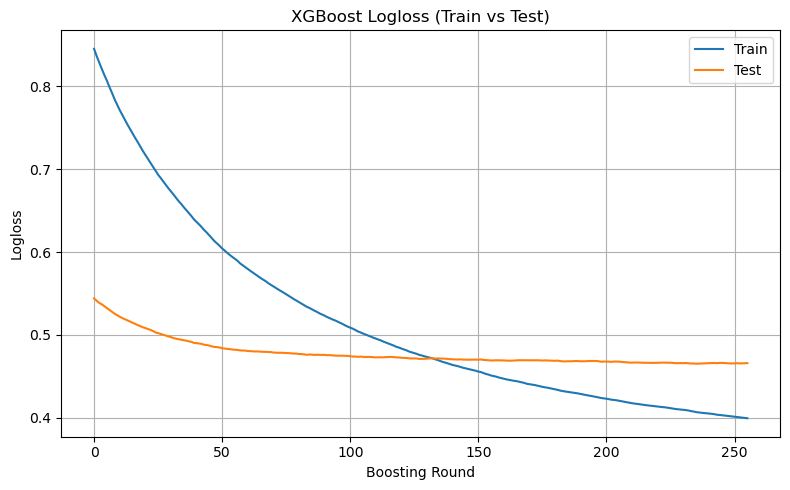

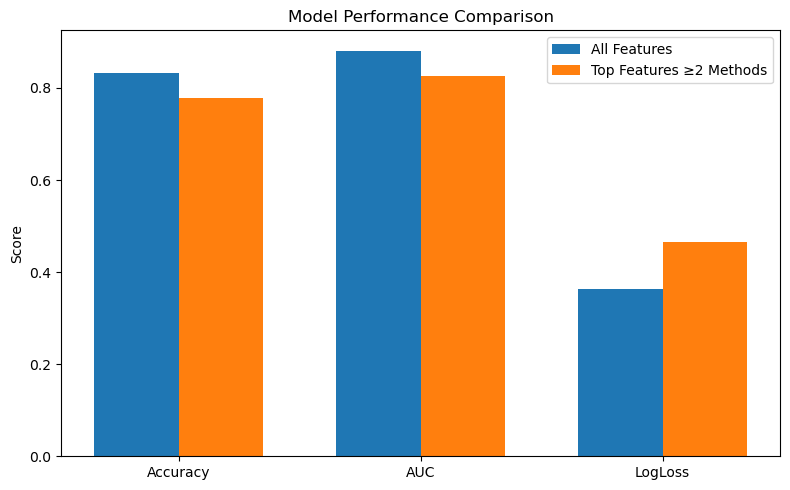

特征数量对比：全特征 = 790，筛选特征 = 53


In [5]:
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

# 1. 构造“出现次数≥2”的特征子集
all_top_features = shap_top_features + pca_top_features + se_top_features
feature_counter = Counter(all_top_features)

# 2. 筛选出现 ≥2 次的特征
selected_features = [feat for feat, count in feature_counter.items() if count >= 2]
print(f"出现在 ≥2 个方法中的特征数：{len(selected_features)}")

# 注意：X_train_enc 和 X_test_enc 是第一次划分之后做的 One-Hot 编码结果
X_selected_train = X_train_enc[selected_features]
X_selected_test = X_test_enc[selected_features]

# 标准化
scaler = StandardScaler()
X_selected_train_scaled = scaler.fit_transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)
# SMOTE 仅作用于训练集
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_selected_train_scaled, y_train)

# 构造 DMatrix
dtrain = xgb.DMatrix(X_res, label=y_res)
dtest = xgb.DMatrix(X_selected_test_scaled, label=y_test)

params = {
    'eta': 0.01,
    'objective': 'binary:logistic',
    'subsample': 0.5,
    'base_score': y_train.mean(),
    'eval_metric': 'logloss'
}

evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=100
)


y_pred_proba = model.predict(dtest)
y_pred_label = (y_pred_proba >= 0.5).astype(int)

acc_sel = accuracy_score(y_test, y_pred_label)
auc_sel = roc_auc_score(y_test, y_pred_proba)
roc_sel = roc_auc_score(y_test, y_pred_proba)
logloss_sel = log_loss(y_test, y_pred_proba)


# 模型评估输出
print(f"Accuracy: {acc_sel:.4f}")
print(f"AUC: {auc_sel:.4f}")
print(f"LogLoss: {logloss_sel:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_label))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_label))

# logloss曲线
epochs = len(evals_result['train']['logloss'])
plt.figure(figsize=(8,5))
plt.plot(range(epochs), evals_result['train']['logloss'], label='Train')
plt.plot(range(epochs), evals_result['test']['logloss'], label='Test')
plt.xlabel("Boosting Round")
plt.ylabel("Logloss")
plt.title("XGBoost Logloss (Train vs Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. 可视化性能对比
acc_full = 0.8322
auc_full = 0.8811
logloss_full = 0.36403
n_feat_full = X_train_enc.shape[1]
n_feat_sel = len(selected_features)

metrics = ['Accuracy', 'AUC', 'LogLoss']
full_model = [acc_full, auc_full, logloss_full]
sel_model = [acc_sel, auc_sel, logloss_sel]

x = np.arange(len(metrics))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, full_model, width=bar_width, label='All Features')
plt.bar(x + bar_width, sel_model, width=bar_width, label='Top Features ≥2 Methods')
plt.xticks(x + bar_width / 2, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

print(f"特征数量对比：全特征 = {n_feat_full}，筛选特征 = {n_feat_sel}")

In [6]:
!pip install catboost


                 Model  Accuracy       AUC  F1 Score  Precision    Recall
2        Random Forest  0.827115  0.845131  0.889340   0.868993  0.911071
3  Logistic Regression  0.810555  0.789923  0.881465   0.842261  0.924740
4             CatBoost  0.805375  0.829493  0.880572   0.826964  0.941838
0              XGBoost  0.812355  0.833387  0.880451   0.856031  0.906513
1       XGB_train (原生)  0.799277       NaN  0.875526   0.829678  0.927026


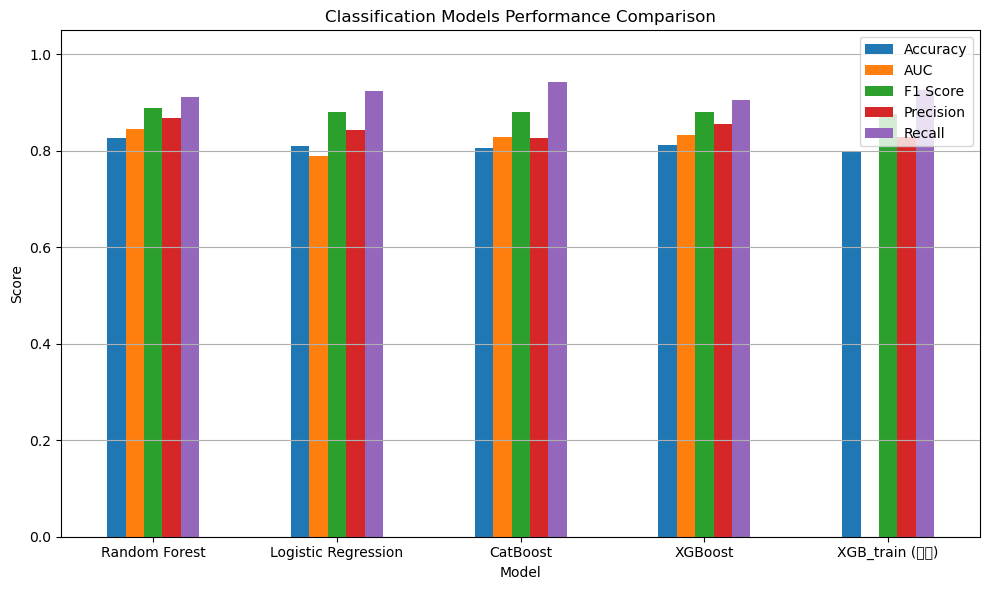

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

import xgboost as xgb
from sklearn.base import BaseEstimator, ClassifierMixin

class XGBTrainWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, num_boost_round=100, early_stopping_rounds=20):
        self.params = params or {
            'eta': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss'
        }
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds
        self.model = None
    
    def fit(self, X, y, eval_set=None):
        dtrain = xgb.DMatrix(X, label=y)
        
        # eval_set format: [(X_val, y_val)]
        evals = []
        if eval_set:
            dval = xgb.DMatrix(eval_set[0][0], label=eval_set[0][1])
            evals = [(dtrain, 'train'), (dval, 'eval')]
        else:
            evals = [(dtrain, 'train')]

        self.model = xgb.train(
            self.params,
            dtrain,
            num_boost_round=self.num_boost_round,
            evals=evals,
            early_stopping_rounds=self.early_stopping_rounds,
            verbose_eval=False
        )
        return self

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return (self.model.predict(dtest) >= 0.5).astype(int)

    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        prob = self.model.predict(dtest)
        return np.vstack([1 - prob, prob]).T

# 准备模型
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'XGB_train (原生)': XGBTrainWrapper(), 
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# 存储结果
results = []

for name, model in models.items():
    acc = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='accuracy').mean()
    auc = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='roc_auc').mean()
    f1 = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='f1').mean()
    precision = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='precision').mean()
    recall = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='recall').mean()
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "AUC": auc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

# 展示结果
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='F1 Score', ascending=False)
print(df_results)

# 可视化
df_results.set_index("Model")[["Accuracy", "AUC", "F1 Score", "Precision", "Recall"]].plot(kind='bar', figsize=(10,6))
plt.title("Classification Models Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_selected_train_scaled, y_train)

print("最佳参数：", random_search.best_params_)
print("最佳得分（F1）：", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
最佳参数： {'subsample': 0.6, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.6}
最佳得分（F1）： 0.8851179489264813


In [9]:
best_params = random_search.best_params_

best_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
best_model.fit(X_selected_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
y_pred_proba = best_model.predict_proba(X_selected_test_scaled)[:, 1]
y_pred_label = (y_pred_proba >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix

acc = accuracy_score(y_test, y_pred_label)
auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)

print(f"测试集 Accuracy: {acc:.4f}")
print(f"测试集 AUC: {auc:.4f}")
print(f"测试集 LogLoss: {logloss:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_label))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_label))


测试集 Accuracy: 0.8264
测试集 AUC: 0.8537
测试集 LogLoss: 0.3891
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.51      0.58        68
           1       0.86      0.92      0.89       220

    accuracy                           0.83       288
   macro avg       0.77      0.72      0.74       288
weighted avg       0.82      0.83      0.82       288

Confusion Matrix:
 [[ 35  33]
 [ 17 203]]


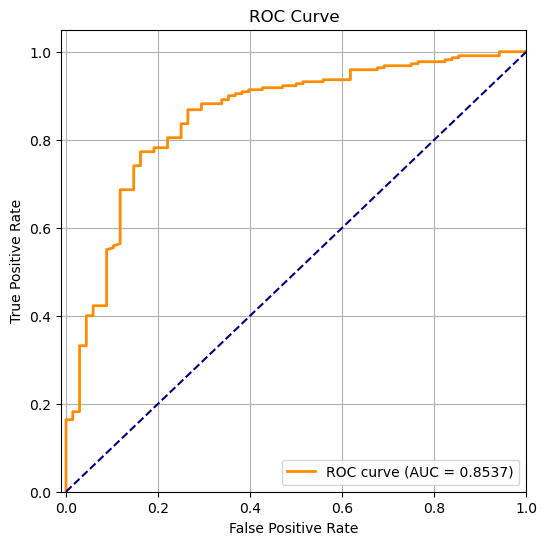

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 获取预测概率（正类）
y_score = best_model.predict_proba(X_selected_test_scaled)[:, 1]

# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 画图
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


最佳阈值为: 0.55, 对应 F1 分数为: 0.8973


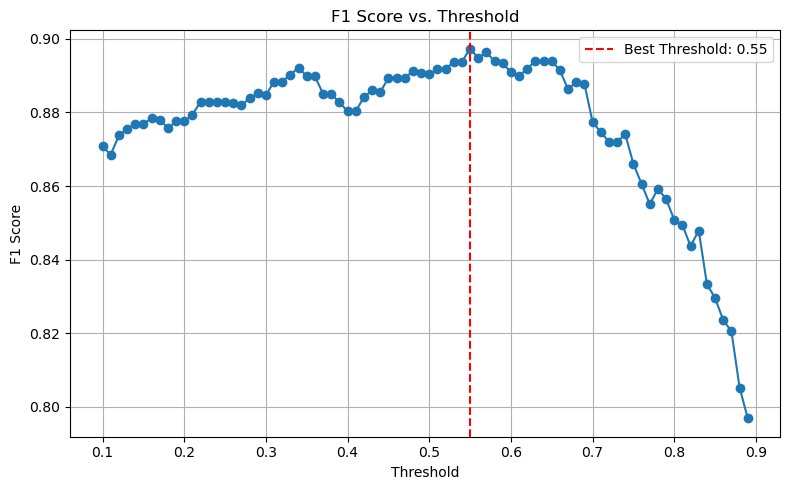

In [12]:
from sklearn.metrics import f1_score

best_threshold = 0.5
best_f1 = 0

thresholds = np.arange(0.1, 0.9, 0.01)  # 可以微调步长
f1_list = []

for threshold in thresholds:
    y_pred_tmp = (y_score >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_tmp)
    f1_list.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"最佳阈值为: {best_threshold:.2f}, 对应 F1 分数为: {best_f1:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_list, marker='o')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
y_pred_best = (y_score >= best_threshold).astype(int)

acc = accuracy_score(y_test, y_pred_best)
auc_score = roc_auc_score(y_test, y_score)
logloss = log_loss(y_test, y_score)

print("使用最佳阈值后表现：")
print(f"Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, LogLoss: {logloss:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


使用最佳阈值后表现：
Accuracy: 0.8403, AUC: 0.8537, LogLoss: 0.3891
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.60      0.64        68
           1       0.88      0.91      0.90       220

    accuracy                           0.84       288
   macro avg       0.78      0.76      0.77       288
weighted avg       0.83      0.84      0.84       288

Confusion Matrix:
 [[ 41  27]
 [ 19 201]]


In [14]:
import joblib

# 创建包含模型和阈值的字典
model_package = {
    'model': best_model,
    'threshold': 0.58
}

# 保存
joblib.dump(model_package, 'best_model_with_threshold.pkl')


['best_model_with_threshold.pkl']